# TEST PUNCC - Conformal prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('default')
import os
# %matplotlib inline: only draw static
# images in the notebook
%matplotlib inline

In [2]:
from sklearn.ensemble import RandomForestRegressor,HistGradientBoostingRegressor
from deel.puncc.api.prediction import BasePredictor,MeanVarPredictor,DualPredictor
from deel.puncc.regression import SplitCP,CQR,LocallyAdaptiveCP,EnbPI,AdaptiveEnbPI,CVPlus
from deel.puncc.plotting import plot_prediction_intervals
from deel.puncc.api.conformalization import ConformalPredictor
from deel.puncc.api.prediction import BasePredictor
from deel.puncc.api.calibration import BaseCalibrator
from deel.puncc.api.splitting import KFoldSplitter
from deel.puncc.api import nonconformity_scores
from deel.puncc.api import prediction_sets
from deel.puncc.metrics import regression_mean_coverage
from deel.puncc.metrics import regression_sharpness

# LOAD DATA

In [3]:

def read_split_csv(folder_path):
    """Load csv files in folder path in a dictionnary of pandas dataframes"""
    datasets = dict()
    for f in os.listdir(folder_path):
        print(f)
        datasets[f[:-4]] = pd.read_csv(os.path.join(folder_path, f), index_col=0)

    return datasets

In [4]:
# read csvs for train/val/test + lourd 

datasets = read_split_csv("../../Data/nsw_vol/")
# remove columns 
cols_ignored = ["linear_acceleration_x","velocity_y","speed","time_start","battery_voltage","battery_current","power_smoothed","position_x","position_y","altitude","route"]
target = ["power"]
datasets['lourd'] = datasets['lourd'].drop(columns = cols_ignored)
datasets['da']= datasets['da'].drop(columns =["linear_acceleration_x"])
datasets['da']= datasets['da'].drop(columns =["velocity_y"])
datasets['da']=datasets['da'].rename({'power_smoothed': 'power'}, axis='columns')
datasets['da'].loc[:,'flight'] = 1
datasets['da'].loc[:,'payload'] = 0
datasets['da']=datasets['da'][datasets['train'].columns]


print(datasets['train'].columns)
print(len(datasets['train'].columns))
print(datasets['lourd'].columns)
print(len(datasets['lourd'].columns))
print(datasets['da'].columns)
print(len(datasets['da'].columns))


datasets['da']['power'].median()

.~lock.da.csv#
train.csv
test.csv
da.csv
lourd.csv
Index(['flight', 'time', 'wind_speed', 'wind_angle', 'position_z',
       'orientation_x', 'orientation_y', 'orientation_z', 'orientation_w',
       'velocity_x', 'velocity_z', 'angular_x', 'angular_y', 'angular_z',
       'linear_acceleration_y', 'linear_acceleration_z', 'payload', 'power'],
      dtype='object')
18
Index(['flight', 'time', 'wind_speed', 'wind_angle', 'position_z',
       'orientation_x', 'orientation_y', 'orientation_z', 'orientation_w',
       'velocity_x', 'velocity_z', 'angular_x', 'angular_y', 'angular_z',
       'linear_acceleration_y', 'linear_acceleration_z', 'payload', 'power'],
      dtype='object')
18
Index(['flight', 'time', 'wind_speed', 'wind_angle', 'position_z',
       'orientation_x', 'orientation_y', 'orientation_z', 'orientation_w',
       'velocity_x', 'velocity_z', 'angular_x', 'angular_y', 'angular_z',
       'linear_acceleration_y', 'linear_acceleration_z', 'payload', 'power'],
      dtype='obje

471.0454

In [5]:
df_train=datasets['train']
df_train=df_train.sort_values(by=['time'])
X_train=df_train[df_train.columns[:-1]]
X_train=X_train.values
y_train=df_train[df_train.columns[-1]]
y_train=y_train.values
print ('Number of samples in train : {}'.format(X_train.shape[0]))

Number of samples in train : 175412


# Linear prediction and Split onformal prediction (SplitCP)

In [6]:



# Create a HistGradientBoostingRegressor model and wrap it in a predictor
rf_model = HistGradientBoostingRegressor(loss="squared_error",random_state=42, 
                                         max_iter=200, learning_rate=0.3)
rf_predictor = BasePredictor(rf_model, is_trained=False)

# CP method initialization
cp_method = SplitCP(rf_predictor)

# The call to `fit` trains the model and computes the nonconformity
# scores on the calibration set
cp_method.fit(X=X_train, y=y_train, fit_ratio=.8)


# CQR 

In [67]:
 # Lower quantile regressor
regressor_q_low = HistGradientBoostingRegressor(max_iter=200, learning_rate=0.3,loss="quantile", quantile=.2/2 )
# Upper quantile regressor
regressor_q_hi = HistGradientBoostingRegressor(max_iter=200, learning_rate=0.3,loss="quantile", quantile=1 - .2/2)
# Wrap models in predictor
rf_predictor = DualPredictor(models=[regressor_q_low, regressor_q_hi])

# CP method initialization
cp_method = CQR(rf_predictor)

# The call to `fit` trains the model and computes the nonconformity
# scores on the calibration set
cp_method.fit(X=X_train, y=y_train, fit_ratio=.8)

# LocallyAdaptiveCP

In [10]:
# Create two models mu (mean) and sigma (dispersion)

mu_model = HistGradientBoostingRegressor(loss="squared_error",random_state=42, 
                                         max_iter=200, learning_rate=0.3)
sigma_model = HistGradientBoostingRegressor(loss="squared_error",random_state=42, 
                                         max_iter=200, learning_rate=0.3)


# Wrap models in a mean/variance predictor
mean_var_predictor = MeanVarPredictor(models=[mu_model, sigma_model])

# CP method initialization
cp_method = LocallyAdaptiveCP(mean_var_predictor)

# The call to `fit` trains the model and computes the nonconformity
# scores on the calibration set
cp_method.fit(X=X_train, y=y_train, fit_ratio=.8)

# CV + (cross-validation) method

In [20]:
# Create a HistGradientBoostingRegressor model and wrap it in a predictor
rf_model = HistGradientBoostingRegressor(loss="squared_error",random_state=42, 
                                         max_iter=200, learning_rate=0.3)
rf_predictor = BasePredictor(rf_model, is_trained=False)

# CP method initialization
cp_method = CVPlus(rf_predictor, K=20, random_state=42)

# The call to `fit` trains the model and computes the nonconformity
# scores on the K-fold calibration sets
cp_method.fit(X=X_train, y=y_train)

# Ensemble Batch Prediction Intervals (EnbPI) method

In [31]:
# Create rf regressor
rf_model = HistGradientBoostingRegressor(loss="squared_error",random_state=42, max_iter=200, learning_rate=0.3)
# Wrap model in a predictor
rf_predictor = BasePredictor(rf_model)
# CP method initialization
cp_method = EnbPI(rf_predictor,B=30, agg_func_loo=np.mean,random_state=42)

# The call to `fit` trains the model and computes the nonconformity
# scores on the calibration set
cp_method.fit(X=X_train, y=y_train)

# Adaptive EnbPI method

In [41]:
# Create two models mu (mean) and sigma (dispersion)

mu_model = HistGradientBoostingRegressor(loss="squared_error",random_state=42, 
                                         max_iter=200, learning_rate=0.3)
sigma_model = HistGradientBoostingRegressor(loss="squared_error",random_state=42, 
                                         max_iter=200, learning_rate=0.3)

# Wrap models in a mean/variance predictor
mean_var_predictor = MeanVarPredictor(models=[mu_model, sigma_model])

# CP method initialization
cp_method = AdaptiveEnbPI(mean_var_predictor,B=30, agg_func_loo=np.mean,random_state=42)

# The call to `fit` trains the model and computes the nonconformity
# scores on the calibration set
cp_method.fit(X=X_train, y=y_train)

# TEST

In [42]:
#### Test
df_test=datasets['test']
df_test=df_test[df_test["flight"]==1]   
X_test=df_test[df_test.columns[:-1]]
X_test=X_test.values
y_test=df_test[df_test.columns[-1]]
y_test=y_test.values

print ('Number of samples in test : {}'.format(X_test.shape[0]))

Number of samples in test : 1132


# LOURD

In [48]:
#### Test
df_test=datasets['lourd']
df_test=df_test[df_test["flight"]==76]   #60,156,210
X_test=df_test[df_test.columns[:-1]]
X_test=X_test.values
y_test=df_test[df_test.columns[-1]]
y_test=y_test.values

print ('Number of samples in test : {}'.format(X_test.shape[0]))

Number of samples in test : 1086


# DA 

In [51]:
#### DA
df_test=datasets['da']
X_test=df_test[df_test.columns[:-1]]
X_test=X_test.values
y_test=df_test[df_test.columns[-1]]
y_test=y_test.values
print ('Number of samples in test : {}'.format(X_test.shape[0]))

Number of samples in test : 565


# PREDICT

In [52]:

# The predict method infers prediction intervals with respect to
# the significance level alpha = 10%
y_pred, y_pred_lower, y_pred_upper = cp_method.predict(X_test, alpha=.1)
# Compute marginal coverage and average width of the prediction intervals
coverage = regression_mean_coverage(y_test, y_pred_lower, y_pred_upper)
width = regression_sharpness(y_pred_lower=y_pred_lower,
                                     y_pred_upper=y_pred_upper)
print(f"Marginal coverage: {np.round(coverage, 2)}")
print(f"Average width: {np.round(width, 2)}")





Marginal coverage: 0.58
Average width: 102.61


# Visualisation

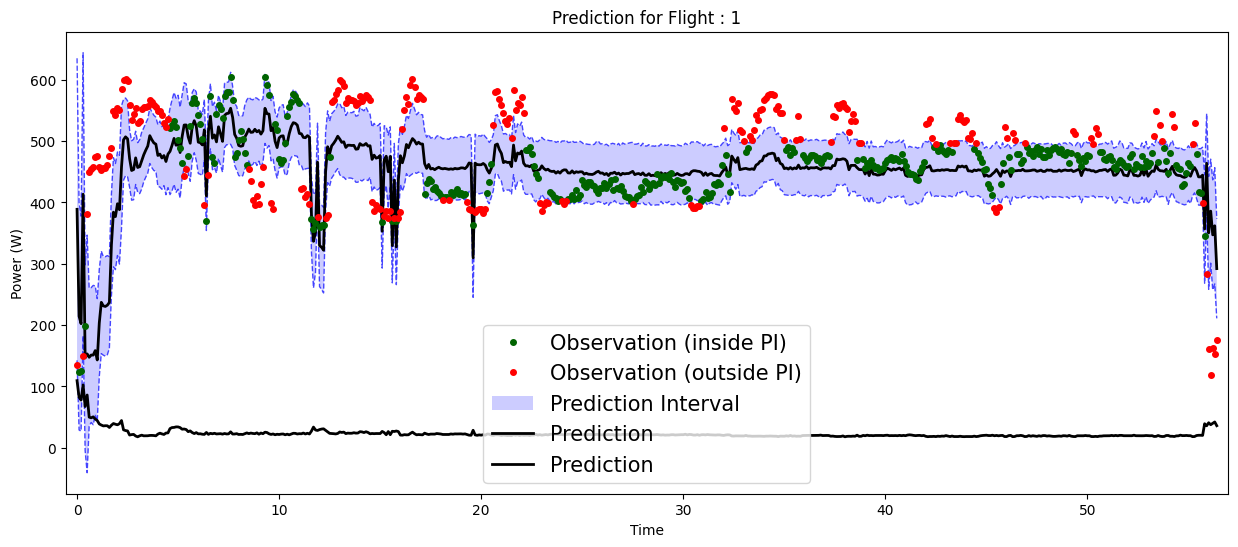

In [53]:
ax = plot_prediction_intervals(
        X = X_test[:,1],
        y_true=y_test,
        y_pred=y_pred,
        y_pred_lower=y_pred_lower,
        y_pred_upper=y_pred_upper,
        loc="lower center")

_ = ax.set_xlabel("Time")
_ = ax.set_ylabel("Power (W)")
_ = ax.set_title( 'Prediction for Flight : {}'.format((int)(X_test[0,0])))